# PySpark Data Preprocessing Pipeline

This notebook demonstrates a typical data preprocessing workflow using PySpark:
1. Data Cleaning (missing data processing, error removal)
2. Data Encoding
3. Data Normalization
4. Dimension Reduction

In [1]:
# Step 1: Data Cleaning (missing data processing, error removal)
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

spark = SparkSession.builder.appName("DataPreprocessing").getOrCreate()

# Read CSV file
df = spark.read.csv("../data/flows.csv", header=True, inferSchema=True)

# select collumns
columns_to_keep = [
    "protocol",
    "application_name",
    "src2dst_packets",
    "dst2src_packets",
    "src2dst_bytes",
    "dst2src_bytes",
    "bidirectional_duration_ms",
    "bidirectional_min_ps",
    "bidirectional_max_ps",
    "bidirectional_mean_ps",
    "bidirectional_stddev_ps",
    "src2dst_max_ps",
    "src2dst_min_ps",
    "src2dst_mean_ps",
    "src2dst_stddev_ps",
    "dst2src_max_ps",
    "dst2src_min_ps",
    "dst2src_mean_ps",
    "dst2src_stddev_ps",
    "bidirectional_mean_piat_ms",
    "bidirectional_stddev_piat_ms",
    "bidirectional_max_piat_ms",
    "bidirectional_min_piat_ms",
    "src2dst_mean_piat_ms",
    "src2dst_stddev_piat_ms",
    "src2dst_max_piat_ms",
    "src2dst_min_piat_ms",
    "dst2src_mean_piat_ms",
    "dst2src_stddev_piat_ms",
    "dst2src_max_piat_ms",
    "dst2src_min_piat_ms",
    "bidirectional_fin_packets",
    "bidirectional_syn_packets",
    "bidirectional_rst_packets",
    "bidirectional_psh_packets",
    "bidirectional_ack_packets",
    "bidirectional_urg_packets",
    "bidirectional_cwr_packets",
    "bidirectional_ece_packets",
    "src2dst_psh_packets",
    "dst2src_psh_packets",
    "src2dst_urg_packets",
    "dst2src_urg_packets"
    ]

# Filter columns
df = df.select([col(c) for c in columns_to_keep])

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/02 06:45:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
from pyspark.sql.functions import isnan, isnull

# Show samples with missing (NaN) values
nan_condition = None
for c in df.columns:
    cond = isnull(col(c)) | isnan(col(c))
    nan_condition = cond if nan_condition is None else nan_condition | cond

df.filter(nan_condition).show(5, truncate=False)

25/06/02 06:45:27 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------+----------------+---------------+---------------+-------------+-------------+-------------------------+--------------------+--------------------+---------------------+-----------------------+--------------+--------------+---------------+-----------------+--------------+--------------+---------------+-----------------+--------------------------+----------------------------+-------------------------+-------------------------+--------------------+----------------------+-------------------+-------------------+--------------------+----------------------+-------------------+-------------------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------+-------------------+-------------------+-------------------+
|protocol|application_name|src2dst_packets|dst2src_packets|src2dst_bytes|dst2src_bytes|bidirectional_durat

In [3]:
# Check the data type of the "application_name" column
print(df.schema["application_name"].dataType)
# Output: StringType()

StringType()


In [4]:
#Drop rows with any missing values
df_clean = df.dropna()

df_clean.show(truncate=True)

+--------+----------------+---------------+---------------+-------------+-------------+-------------------------+--------------------+--------------------+---------------------+-----------------------+--------------+--------------+-----------------+------------------+--------------+--------------+------------------+------------------+--------------------------+----------------------------+-------------------------+-------------------------+--------------------+----------------------+-------------------+-------------------+--------------------+----------------------+-------------------+-------------------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------+-------------------+-------------------+-------------------+
|protocol|application_name|src2dst_packets|dst2src_packets|src2dst_bytes|dst2src_bytes|bidirectiona

In [5]:
# Step 2: Data Encoding (convert categorical columns to numeric)
from pyspark.ml.feature import StringIndexer

# Correct way to check for string columns in PySpark schema
from pyspark.sql.types import StringType

categorical_cols = [field.name for field in df_clean.schema.fields if isinstance(field.dataType, StringType)]
numeric_cols = [field.name for field in df_clean.schema.fields if field.dataType.typeName() in ['integer', 'double', 'long', 'float']]

print("Categorical columns:", categorical_cols)

# Check non-null counts for application_name
print("Number of rows after dropna():", df_clean.count())
df_clean.select("application_name").groupBy("application_name").count().show()

for col_name in categorical_cols:
    indexer = StringIndexer(inputCol=col_name, outputCol=col_name + "_idx").fit(df_clean)
    df_clean = indexer.transform(df_clean)

df_encoded = df_clean
show_cols = categorical_cols + [c + "_idx" for c in categorical_cols]
df_encoded.select(*show_cols).show(5)

print(df_clean.printSchema())

Categorical columns: ['application_name']
Number of rows after dropna(): 1850
+------------------+-----+
|  application_name|count|
+------------------+-----+
|               DNS|    1|
|              MDNS|    4|
|              IGMP|  168|
|              SSDP|   65|
|               TLS|    1|
|TLS.GoogleServices|    1|
|            ICMPV6|  449|
|               NTP|    6|
|DNS.GoogleServices|    1|
|           NetBIOS|    6|
|              HTTP| 1148|
+------------------+-----+

+----------------+--------------------+
|application_name|application_name_idx|
+----------------+--------------------+
|            HTTP|                 0.0|
|            HTTP|                 0.0|
|          ICMPV6|                 1.0|
|            HTTP|                 0.0|
|          ICMPV6|                 1.0|
+----------------+--------------------+
only showing top 5 rows

root
 |-- protocol: integer (nullable = true)
 |-- application_name: string (nullable = true)
 |-- src2dst_packets: integer (nullab

In [6]:
# Step 3: Data Normalization (scale numeric features)
from pyspark.ml.feature import VectorAssembler, MinMaxScaler, StandardScaler

# Use only indexed categorical and numeric columns for features
feature_cols = [col+"_idx" for col in categorical_cols] + numeric_cols

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_vec")
df_features = assembler.transform(df_encoded)

scaler = StandardScaler(inputCol="features_vec", outputCol="features_scaled")
scaler_model = scaler.fit(df_features)
df_scaled = scaler_model.transform(df_features)

df_scaled.select("features_scaled").show(5, truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features_scaled                                                                                                                                                                                                                                                                                           

In [7]:
# Step 4: Dimension Reduction (PCA)
from pyspark.ml.feature import PCA

# Reduce to 3 principal components (adjust k as needed)
pca = PCA(k=3, inputCol="features_scaled", outputCol="pca_features")
pca_model = pca.fit(df_scaled)
df_pca = pca_model.transform(df_scaled)

df_pca.select("pca_features").show(5, truncate=False)

25/06/02 06:45:31 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/06/02 06:45:31 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
25/06/02 06:45:31 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


+------------------------------------------------------------+
|pca_features                                                |
+------------------------------------------------------------+
|[4.221304406828352,-0.16819104919511302,-3.595271812888252] |
|[8.079620218909975,-0.6071544769397238,-3.6671973501119317] |
|[-2.7865698901435585,-13.684580422349539,-5.162522893140019]|
|[10.096230574189756,-1.8789470874210616,-5.962559594593144] |
|[-0.20195824826506614,0.5649179203488945,-5.436386680769083]|
+------------------------------------------------------------+
only showing top 5 rows



Matplotlib created a temporary cache directory at /tmp/matplotlib-oqc6pcke because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


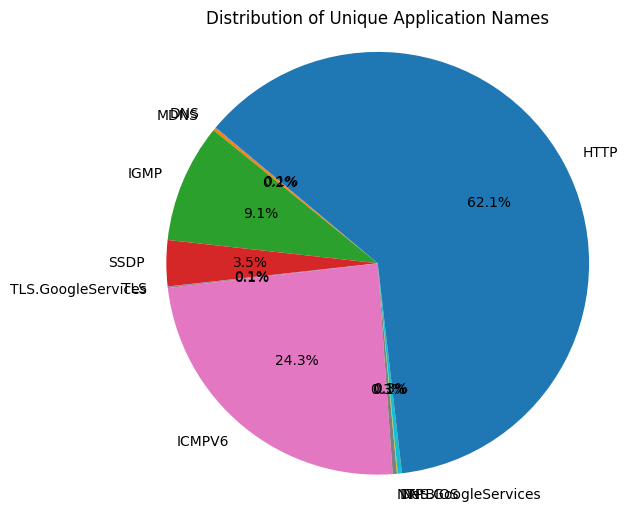

In [8]:
import matplotlib.pyplot as plt

# Get unique application_name counts
app_counts = df_clean.groupBy("application_name").count().toPandas()

plt.figure(figsize=(6, 6))
plt.pie(app_counts['count'], labels=app_counts['application_name'], autopct='%1.1f%%', startangle=140)
plt.title("Distribution of Unique Application Names")
plt.axis('equal')
plt.show()

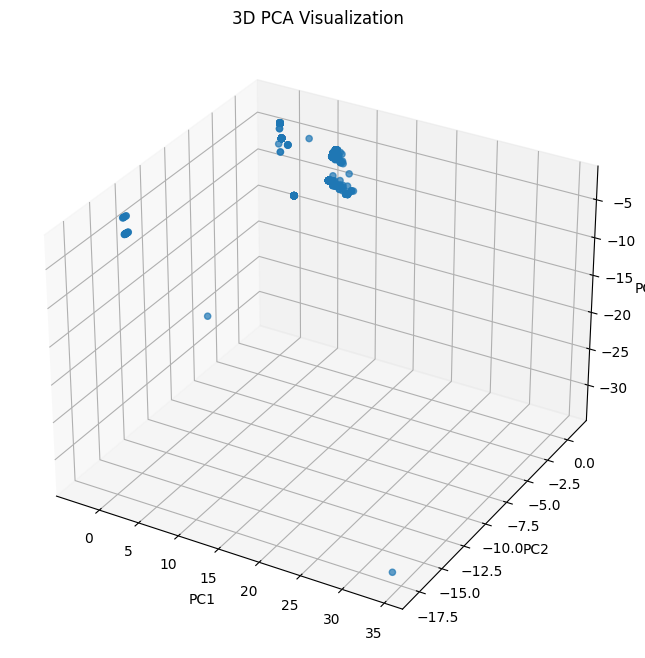

In [9]:
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

# Collect the first 1000 rows for visualization (adjust as needed)
pca_data = df_pca.select("pca_features").limit(1000).toPandas()

# Extract PCA features into separate columns
pca_features = pca_data["pca_features"].apply(lambda x: x.toArray())
pca_df = pd.DataFrame(pca_features.tolist(), columns=["PC1", "PC2", "PC3"])

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    pca_df["PC1"], pca_df["PC2"], pca_df["PC3"],
    alpha=0.7
)

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("3D PCA Visualization")

plt.show()


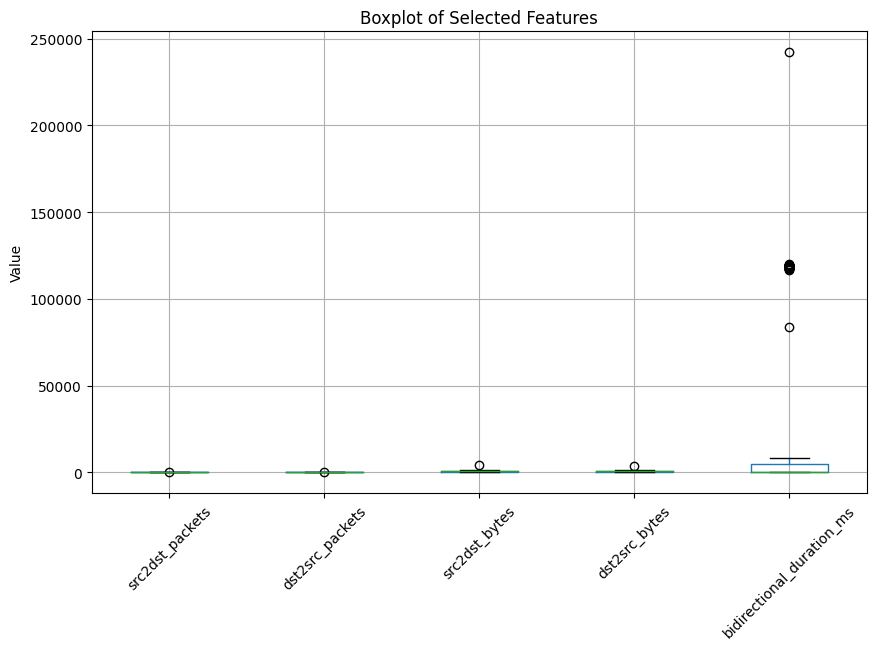

In [10]:
# Select a few numeric columns to visualize
boxplot_cols = [
    "src2dst_packets",
    "dst2src_packets",
    "src2dst_bytes",
    "dst2src_bytes",
    "bidirectional_duration_ms"
]

# Collect data for boxplot (limit rows for performance)
boxplot_data = df_clean.select(boxplot_cols).limit(1000).toPandas()

plt.figure(figsize=(10, 6))
boxplot_data.boxplot(column=boxplot_cols)
plt.title("Boxplot of Selected Features")
plt.ylabel("Value")
plt.xticks(rotation=45)
plt.show()

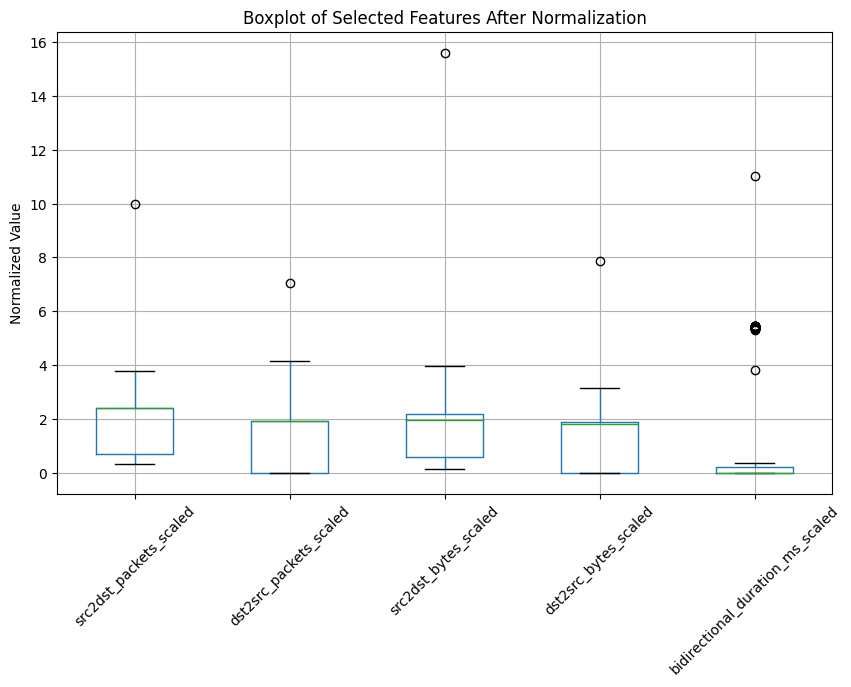

In [11]:
from pyspark.ml.functions import vector_to_array

# Convert features_scaled vector to array
df_scaled_array = df_scaled.withColumn("features_array", vector_to_array("features_scaled"))

# Get indices of your desired columns in feature_cols
boxplot_indices = [feature_cols.index(col) for col in boxplot_cols]

# Select the corresponding features from the array
for i, col_name in zip(boxplot_indices, boxplot_cols):
    df_scaled_array = df_scaled_array.withColumn(col_name + "_scaled", df_scaled_array["features_array"][i])

# Now you can select the new *_scaled columns for plotting
scaled_boxplot_data = df_scaled_array.select([c + "_scaled" for c in boxplot_cols]).limit(1000).toPandas()
plt.figure(figsize=(10, 6))
scaled_boxplot_data.boxplot(column=[c + "_scaled" for c in boxplot_cols])
plt.title("Boxplot of Selected Features After Normalization")
plt.ylabel("Normalized Value")
plt.xticks(rotation=45)
plt.show()